#### 1.Importing Libraries and Loading Data

In [1]:
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
import csv
import random
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

det_class_path = '../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv'
bbox_path = '../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'
dicom_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'

# load and shuffle filenames
dicom_dir = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images/'
filenames = os.listdir(dicom_dir)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


**The most interesting group here is the No Lung Opacity / Not Normal since they are cases that look like opacity but are not. 
So the first step might be to divide the test images into clear groups and then only perform the bounding box prediction on the suspicious images.**

In [2]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

30227 class infos loaded
26684 patient cases


,patientId,class
29106,04158595-a45e-402c-94e9-df6fce1bb6bf,Normal
5048,43c2d6d6-13c3-421a-a45e-3b6913bcfdda,No Lung Opacity / Not Normal
7178,54ca2bbe-f8cb-4c30-b128-9a0948f9da4d,Normal


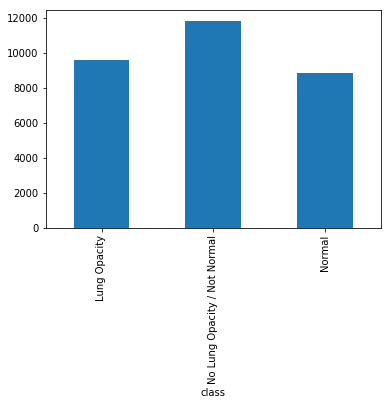

In [3]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

### Load the Bounding Box Data
**Here we show the bounding boxes**

In [4]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

30227 boxes loaded
26684 patient cases


,patientId,x,y,width,height,Target
2690,338e80a6-7b26-4133-b051-a40e063d39a3,300.0,182.0,174.0,193.0,1
12266,7d889abc-6804-4b28-adb3-3540ecb055c6,NaN,NaN,NaN,NaN,0
16039,9b995df9-5372-45f8-8ce8-4465158e86ca,NaN,NaN,NaN,NaN,0


In [5]:
# we first try a join and see that it doesn't work (we end up with too many boxes)
comb_bbox_df = pd.merge(bbox_df, det_class_df, how='inner', on='patientId')
print(comb_bbox_df.shape[0], 'combined cases')

37629 combined cases


### Concatenate

**We have to concatenate the two datasets and then we get class and target information on each region**

In [6]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
3316,379ead0e-f5dc-435b-aea0-3cc8e808de11,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
8502,5fe137e2-d416-4f49-b685-6a3fe5367910,616.0,615.0,187.0,232.0,1,Lung Opacity
12632,804cd23d-d522-444b-84dc-1ba5f5ba97c9,NaN,NaN,NaN,NaN,0,Normal


Distribution of Boxes and Labels
The values below show the number of boxes and the patients that have that number.

In [7]:
box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


How are class and target related?
I assume that all the Target=1 values fall in the Lung Opacity class, but it doesn't hurt to check.

In [8]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


Images
Now that we have the boxes and labels loaded we can examine a few images.

In [9]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

26684 images found


In [10]:
image_bbox_df = pd.merge(comb_box_df, 
                         image_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...


Enrich the image fields
We have quite a bit of additional data in the DICOM header we can easily extract to help learn more about the patient like their age, view position and gender which can make the model much more precise

,BodyPartExamined,ViewPosition,PatientSex
count,26684,26684,26684
unique,1,2,2
top,CHEST,PA,M
freq,26684,14511,15166


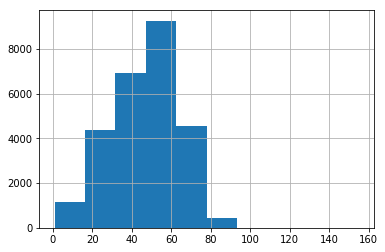

In [11]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [12]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')

Create Sample Data Set
We create a sample dataset covering different cases, and number of boxes

In [13]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,path
0,d27b2708-49f7-4bf3-b2e0-56519eee4d5a,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../input/rsna-pneumonia-detection-challenge/st...
1,a7a7a9f6-3d31-4626-8777-fa2003adb972,NaN,NaN,NaN,NaN,0,Normal,1,../input/rsna-pneumonia-detection-challenge/st...
2,718d6d9e-aa8e-46bf-8b5d-1e42e6f398bf,218.0,638.0,156.0,205.0,1,Lung Opacity,1,../input/rsna-pneumonia-detection-challenge/st...
3,3036fb15-305b-4e9b-93ab-4e555a0fd323,295.0,479.0,154.0,86.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
4,3036fb15-305b-4e9b-93ab-4e555a0fd323,675.0,491.0,234.0,106.0,1,Lung Opacity,2,../input/rsna-pneumonia-detection-challenge/st...
5,e3884258-8083-4b8e-b952-9adc91a7f0f3,148.0,576.0,179.0,114.0,1,Lung Opacity,3,../input/rsna-pneumonia-detection-challenge/st...
6,e3884258-8083-4b8e-b952-9adc91a7f0f3,620.0,441.0,195.0,327.0,1,Lung Opacity,3,../input/rsna-pneumonia-detection-challenge/st...
7,e3884258-8083-4b8e-b952-9adc91a7f0f3,262.0,273.0,143.0,195.0,1,Lung Opacity,3,../input/rsna-pneumonia-detection-challenge/st...
8,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,633.0,128.0,90.0,195.0,1,Lung Opacity,4,../input/rsna-pneumonia-detection-challenge/st...
9,0d5bc737-03de-4bb8-98a1-45b7180c3e0f,342.0,157.0,148.0,113.0,1,Lung Opacity,4,../input/rsna-pneumonia-detection-challenge/st...


Show the position and bounding box
Here we can see the position (point) and the bounding box for each of the different image types

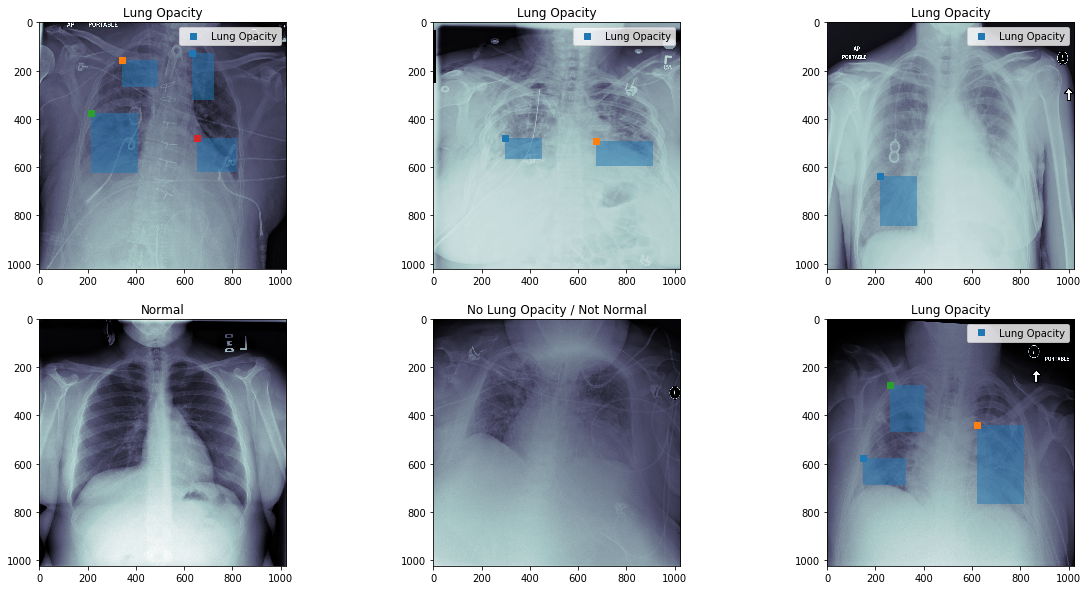

In [14]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

Bounding Box Distribution
Here we just look at the bounding box distribution to get a better idea how this looks over the whole dataset

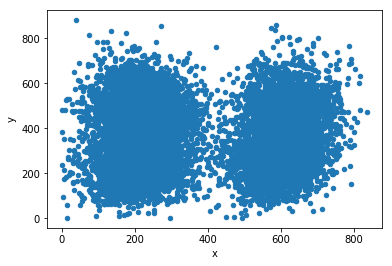

In [15]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

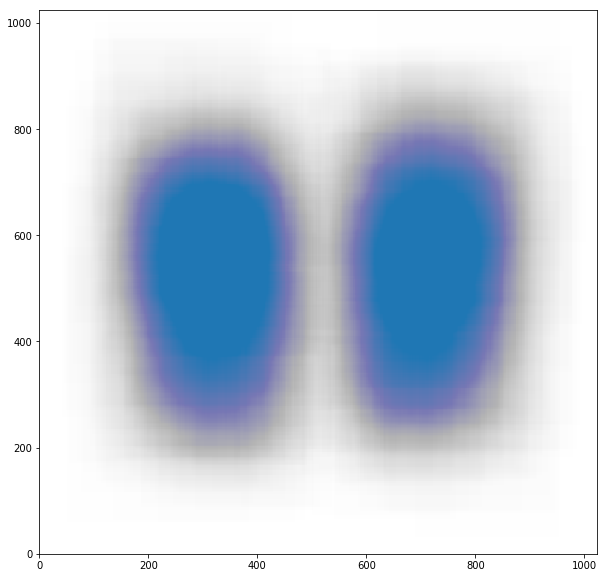

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

### Show the boxes as segmentation

**By showing them as segmentations we can get a better probability map for where the opacity regions are most likely to occur**

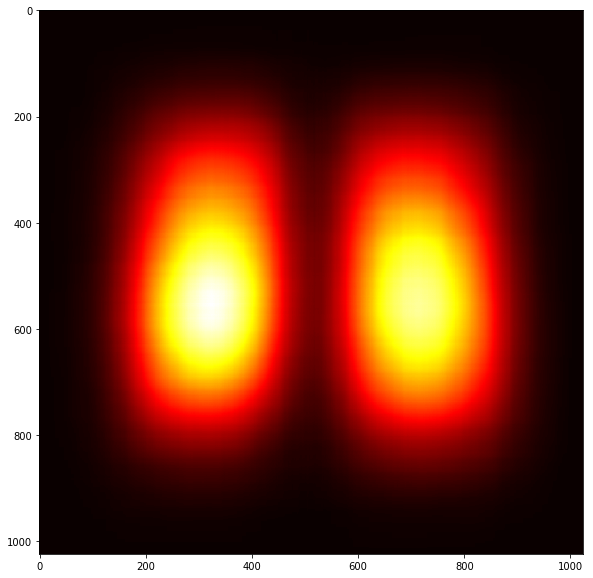

In [17]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

Overlay the Probability on a few images
Does the probability we calculate seem to make sense? or have we flipped something somewhere?

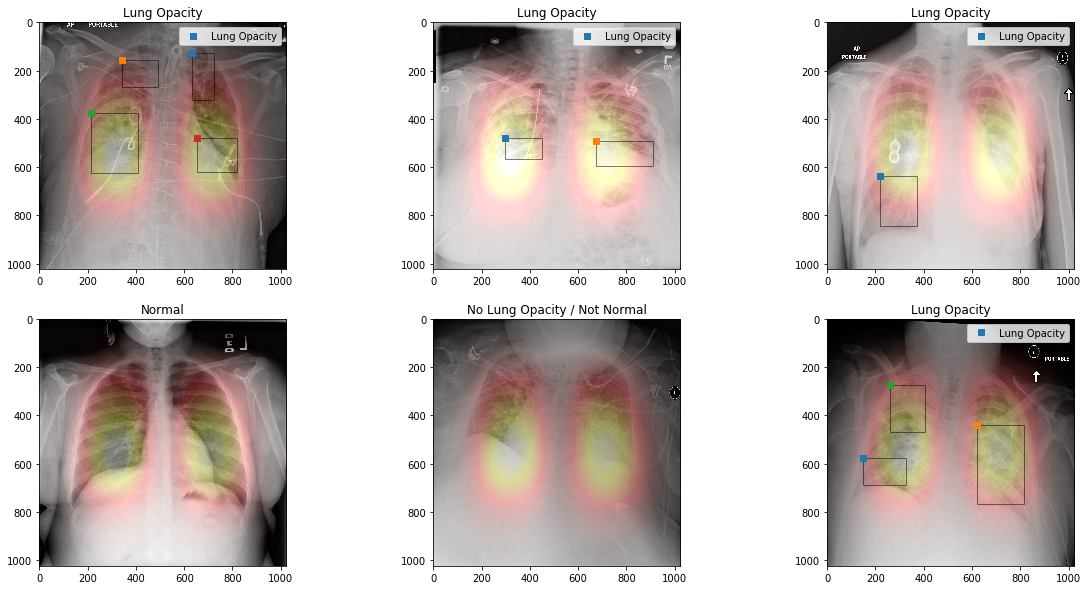

In [18]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)

Save the preprocessed results

We can use the preprocessed results with the appropriate DICOM tags to make model training step easier

In [19]:
image_bbox_df.to_csv('image_bbox_full.csv', index=False)

In [20]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [21]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [22]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, workers=4, use_multiprocessing=True)

Epoch 1/10
753/753 [==============================] - 1592s 2s/step - loss: 0.4851 - acc: 0.9616 - mean_iou: 0.6077 - val_loss: 0.6713 - val_acc: 0.8549 - val_mean_iou: 0.3526
Epoch 2/10
753/753 [==============================] - 1591s 2s/step - loss: 0.4500 - acc: 0.9664 - mean_iou: 0.6658 - val_loss: 0.4987 - val_acc: 0.9706 - val_mean_iou: 0.6672
Epoch 3/10
753/753 [==============================] - 1577s 2s/step - loss: 0.4388 - acc: 0.9680 - mean_iou: 0.6809 - val_loss: 0.4220 - val_acc: 0.9647 - val_mean_iou: 0.6748
Epoch 4/10
753/753 [==============================] - 1576s 2s/step - loss: 0.4282 - acc: 0.9691 - mean_iou: 0.6921 - val_loss: 0.4519 - val_acc: 0.9714 - val_mean_iou: 0.7252
Epoch 5/10
753/753 [==============================] - 1577s 2s/step - loss: 0.4199 - acc: 0.9698 - mean_iou: 0.7014 - val_loss: 0.4141 - val_acc: 0.9677 - val_mean_iou: 0.6982
Epoch 6/10
753/753 [==============================] - 1575s 2s/step - loss: 0.4117 - acc: 0.9707 - mean_iou: 0.7093 - va

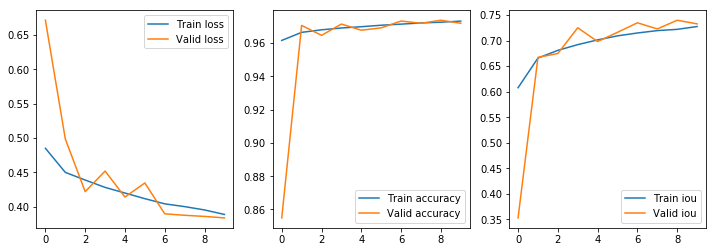

In [23]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

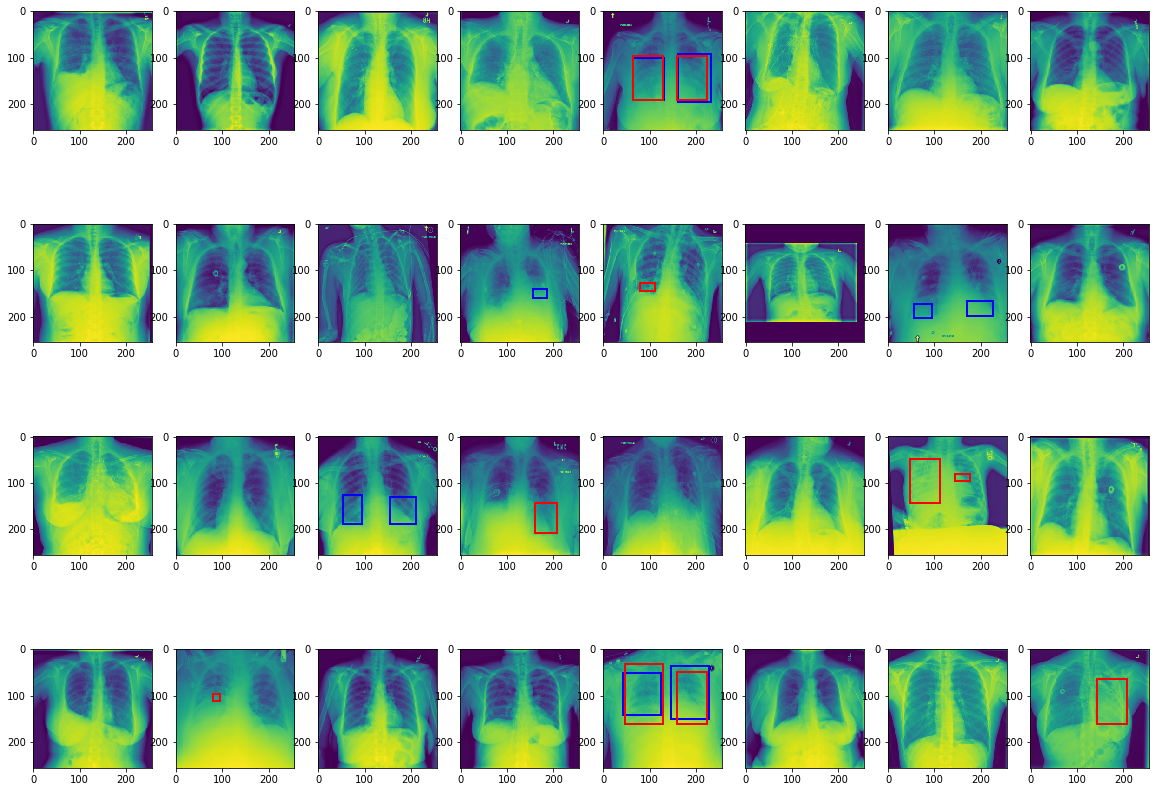

In [24]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [25]:
# load and shuffle filenames
folder = '../input/rsna-pneumonia-detection-challenge/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
